<a href="https://colab.research.google.com/github/haechis/DeepLearning_tutorial/blob/main/Do_it_DeepLearning_201228.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06장, 다층 신경망


In [ ]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다.
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다.
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(x)               # 정방향 계산을 수행합니다.
            a = self.activation(z)            # 활성화 함수를 적용합니다.
            err = -(y - a)                    # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

# 2개의 층을 가진 신경망 구현하기

 - SingleLayer 클래스의 은닉층 부분의 계산을 제외하면 대부분 비슷한 기능
 - -> SingleLayer 클래스를 상속, DualLayer 클래스를 만들고 필요한 메서드만 재정의

 

In [ ]:
## 1. SingleLayer 클래스를 상속한 DualLayer 클래스 만들기
class DualLayer(SingleLayer):

  def __init__(self, units = 10, learning_rate = 0.1, l1 = 0, l2 = 0):
    self.units = units        # 은닉층의 뉴런 개수
    self.w1 = None            # 은닉층의 가중치
    self.b1 = None            # 은닉층의 절편
    self.w2 = None            # 출력층의 가중치
    self.b2 = None            # 출력층의 절편
    self.a1 = None            # 은닉층의 활성화 출력 (역방향 계산에 사용)
    self.losses = []          # 훈련 손실
    self.val_losses = []      # 검증 손실
    self.lr = learning_rate   # 학습률
    self.l1 = l1              # L1 손실 하이퍼파라미터
    self.l2 = l2              # L2 손실 하이퍼파라미터

  def forpass(self,x):
    z1 = np.dot(x,self.w1) + self.b1        # 첫 번째 층의 선형식을 계산한다.
    self.a1 = self.activation(z1)           # 활성화 함수를 적용한다. (SingleLayer로 부터 상속받음)
    z2 = np.dot(self.a1,self.w2) + self.b2  # 두 번째 층의 선형식을 계산한다.
    return z2

  # - 모델 훈련에서 오차를 역전파하는 역할을 한다.
  def backprop(self, x, err): 
    m = len(x)        # 샘플의 개수
    ## 출력층의 가중치와 절편에 대한 그레이디언트를 계산한다.
    # 참고, err: (참값과 예측값의 차이)
    w2_grad = np.dot(self.a1.T,err) / m
    b2_grad = np.sum(err) / m

    ## 시그모이드 함수까지 그레이디언트를 계산한다.
    err_to_hidden = np.dot(err,self.w2.T) * self.a1 * (1 - self.a1)

    ## 은닉층의 가중치와 절편에 대한 그레이디언트를 계산한다.
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden,axis = 0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  ## fit() 메서드를 위한 가중치 초기화 부분
  def inint_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units)) # (특성개수 x 은닉층의 크기)
    self.b1 = np.zeros(self.units)              # (은닉층의 크기)
    self.w2 = np.ones((self.units,1))           # (은닉층의 크기 x 1)
    self.b2 = 0
  
  ## fit () 메서드
  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    y = y.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    m = len(x)
    self.inint_weights(x.shape[1])
    # epochs 만큼 반복
    for i in range(epochs):
      a = self.training(x, y, m)
      # 안전한 로그 계산을 위해 클리핑한다.
      a = np.clip(a, 1e-10, 1-1e-10)
      # 로그 손실과 규제 손실을 더하여 리스트에 추가한다.
      loss = np.sum(-(y*np.log(a) + (1-y) * np.log(1-a)))
      self.losses.append((loss + self.reg_loss())/m)
      # 검증 세트에 대한 손실을 계산한다.
      self.update_val_loss(x_val,y_val)
    
  ## Training
  def training(self, x, y, m):
    z = self.forpass(x)         # 정방향 계산
    a = self.activation(z)      # 활성화 함수
    err = -(y-a)                # 오차 계산
    # 오차를 역전파하여 그레이디언트를 계산한다.
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x,err)
    # 그레이디언트에서 페널티 항의 미분값을 뺀다.
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    # 은닉층의 가중치와 절편을 업데이트 한다.
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    # 출력층의 가중치와 절편을 업데이트 한다.
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  ## reg_loss : 은닉층과 출력층의 가중치에 대한 L1, L2 손실을 계산
  def reg_loss(self):
    # 은닉층과 출력층의 가중치에 규제를 적용한다.
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))



## 모델 훈련하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#  위스콘신 유방암 데이터 세트를 훈련, 검증, 테스트 세트로 나누고 데이터 살펴보기
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify = y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [ ]:
## 훈련 데이터 표준화 전처리하기
# 데이터 세트의 특성을 -> 평균 0, 표준편차 1이 되도록 변환
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

# 훈련 세트, 검증 세트를 표준화 한다.
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [ ]:
## 1. 다층 신경망 모델 훈련하기
# L2 규제는 0.01, epochs는 20,000 / 평가 점수는 SingleLayer 클래스로 훈련한 모델(L2: 0.01, 에포크 10,000과 동일)
# (평가 점수는 동일 / 왜냐하면 문제가 간단, 문제가 복잡했으면 DualLayer 평가 점수가 더 좋았을 것)

dual_layer = DualLayer(l2 = 0.01)
dual_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

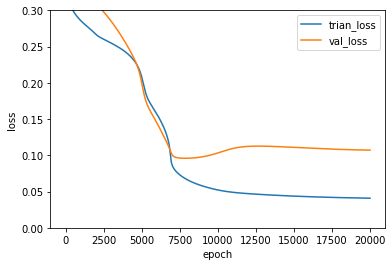

In [ ]:
## 2. 훈련 손실과 검증 손실 그래프 분석하기
# 훈련 손실 그래프는 훈련 데이터로 손실 함수의 최솟값을 찾아가는 과정
# 검증 손실 그래프는 검증 데이터로 손실 함수의 최솟값을 찾아가는 과정
plt.ylim(0,0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trian_loss','val_loss'])
plt.show()

- 위 그래프를 보면, SingLayer 보다 손실 그래프가 천천히 감소

- 이것은 -> 가중치의 개수가 훨씬 많아져서 학습하는 데 시간이 오래 걸림

- 가령, 위슨콘신 유방암 데이터의 특성은 30개 --> SingleLayer 클래스는 가중치 30가와 절편 1개

- DualLayer 클래스는 은닉층의 뉴런이 10개 --> 30 x 10 개의 가중치와 10개의 절편이 필요함 // 출력층 역시 10개 가중치와 1개의 절편이 필요.. --> 총 321개의 가중치를 학습해야함

## 가중치 초기화 개선하기

- 손실 그래프를 보니 초기 손실값이 감소하는 곡선이 매끄럽지 않음

- 아마도 손실 함수가 감소하는 방향을 올바르게 찾는 데 시간이 많이 소요된 듯.

- 지금까지는 가중치를 1로 놓고 훈련하였다.

- 이번에는 정규 분포를 따르는 무작위 수(random.normal)로 가중치를 초기화해보자.

In [ ]:
class RandomInitNetwork(DualLayer):

  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0,1,(n_features,self.units)) # n_featrue: 특성개수 / units: 은닉층의 크기
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0,1,(self.units,1)) # units: 은닉층 크기
    self.b2 = 0
    

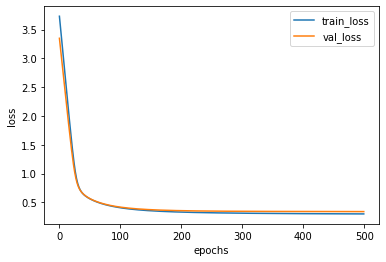

In [ ]:
random_init_net = RandomInitNetwork(l2 = 0.01)
random_init_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 500)
#plt.ylim(0,0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss','val_loss'])
plt.show()

# 06-3 미니 배치를 사용하여 모델을 훈련한다.

## 실전에서 아주 많은 양의 데이터를 배치 경사 하강법으로 하면 어렵다..

## 확률적 경사 하강법과 배치 경사 하강법의 장점을 절충한 미니 배치 경사 하강법을 사용해 보자.

- RandomInitNetwork 클래스를 사용하여 미니 배치 경사 하강법 구현

## 미니 배치 경사 하강법

- 에포크마다 전체 데이터가 아닌 조금씩 나누어 정방향 계산 수행 / 그레이디언트를 구하여 가중치를 업데이트

- 미니 배치 경사 하강법은 작게 나눈 미니 배치만큼 가중치를 업데이트 한다.

- 미니 배치의 크기는 보통 16,32,64 등 2의 배수를 활용

- 미니 배치의 크기가 작으면 확률적 경사 하강법처럼 손실 함수의 전역 최솟값을 찾아 가는 과정이 크게 흔들리는 모양일 것이다.

- 반대로 미니 매치 크기가 충분히 크면 배치 경사 하강법처럼 손실 함수의 전역 최솟값을 안정적으로 찾아갈 것임

- 미니 배치도 하이퍼파라미터 이고, 튜닝의 대상이다.



In [ ]:
## 1. SingleLayer 클래스를 상속한 DualLayer 클래스 만들기
class DualLayer(SingleLayer):

  def __init__(self, units = 10, learning_rate = 0.1, l1 = 0, l2 = 0):
    self.units = units        # 은닉층의 뉴런 개수
    self.w1 = None            # 은닉층의 가중치
    self.b1 = None            # 은닉층의 절편
    self.w2 = None            # 출력층의 가중치
    self.b2 = None            # 출력층의 절편
    self.a1 = None            # 은닉층의 활성화 출력 (역방향 계산에 사용)
    self.losses = []          # 훈련 손실
    self.val_losses = []      # 검증 손실
    self.lr = learning_rate   # 학습률
    self.l1 = l1              # L1 손실 하이퍼파라미터
    self.l2 = l2              # L2 손실 하이퍼파라미터

  def forpass(self,x):
    z1 = np.dot(x,self.w1) + self.b1        # 첫 번째 층의 선형식을 계산한다.
    self.a1 = self.activation(z1)           # 활성화 함수를 적용한다. (SingleLayer로 부터 상속받음)
    z2 = np.dot(self.a1,self.w2) + self.b2  # 두 번째 층의 선형식을 계산한다.
    return z2

  # - 모델 훈련에서 오차를 역전파하는 역할을 한다.
  def backprop(self, x, err): 
    m = len(x)        # 샘플의 개수
    ## 출력층의 가중치와 절편에 대한 그레이디언트를 계산한다.
    # 참고, err: (참값과 예측값의 차이)
    w2_grad = np.dot(self.a1.T,err) / m
    b2_grad = np.sum(err) / m

    ## 시그모이드 함수까지 그레이디언트를 계산한다.
    err_to_hidden = np.dot(err,self.w2.T) * self.a1 * (1 - self.a1)

    ## 은닉층의 가중치와 절편에 대한 그레이디언트를 계산한다.
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden,axis = 0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  ## fit() 메서드를 위한 가중치 초기화 부분
  def inint_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units)) # (특성개수 x 은닉층의 크기)
    self.b1 = np.zeros(self.units)              # (은닉층의 크기)
    self.w2 = np.ones((self.units,1))           # (은닉층의 크기 x 1)
    self.b2 = 0
  
  ## fit () 메서드
  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    y = y.reshape(-1,1)
    self.init_weights(x.shape[1]) ## 은닉층과 출력층의 가중치를 초기화한다.
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      # 제너레이터 함수에서 반환한 미니 배치를 순환한다.
      for x_batch, y_batch in self.gen_batch(x,y):
        y_batch = y_batch.reshape(-1,1)   # 타깃을 열 벡터로 바꾼다.
        m = len(x_batch)
        a = self.training(x_batch,y_batch,m)
        # 클리핑
        a = np.clip(a, 1e-10, 1-1e-10)
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
             

      self.losses.append((loss + self.reg_loss())/m)
      # 검증 세트에 대한 손실을 계산한다.
      self.update_val_loss(x_val,y_val)
    
  ## Training
  def training(self, x, y, m):
    z = self.forpass(x)         # 정방향 계산
    a = self.activation(z)      # 활성화 함수
    err = -(y-a)                # 오차 계산
    # 오차를 역전파하여 그레이디언트를 계산한다.
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x,err)
    # 그레이디언트에서 페널티 항의 미분값을 뺀다.
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    # 은닉층의 가중치와 절편을 업데이트 한다.
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    # 출력층의 가중치와 절편을 업데이트 한다.
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  ## reg_loss : 은닉층과 출력층의 가중치에 대한 L1, L2 손실을 계산
  def reg_loss(self):
    # 은닉층과 출력층의 가중치에 규제를 적용한다.
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))


  ### 파이썬 제너레이터 (generator)로 구현 --> 순차적으로 데이터에 접근할 수 있는 반복 가능한 객체(iterator)를 반환
      # 제너레이터 사용하면 명시적으로 리스트를 만들지 않으면서 필요한 만큼 데이터 추출 가능
      #  yiel 문을 사용한다.
  def gen_batch(self, x, y):
    # gen_batch()는 batch_size 만큼씩 x,y 배열을 건너뛰며 미니 배치를 반환한다.
    # 미니 배치가 똑같은 순서로 반복되지 않도록 에포크마다 훈련 데이터 인덱스를 섞는다.
    length = len(x)
    bins = length // self.batch_size # 미니 배치 횟수
    if length % self.batch_size:
      bins+=1 # 나누어 떨어지지 않을 때
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞는다.
      x = x[indexes]
      y = y[indexes]
      for i in range(bins):
        start = self.batch_size * i
        end = self.batch_size * (i+1)
        yield x[start:end], y[start:end]  # batch_size 만큼 슬라이싱하여 반환


In [ ]:
## 1. MinibatchNetwork 클래스 구현하기
class MinibatchNetwork(RandomInitNetwork):

  def __init__(self, units = 10, batch_size = 32, learning_rate = 0.1, l1 = 0, l2 = 0):
    super().__init__(units, learning_rate, l1, l2)  # super 클래스를 이용하여 부모 클래스를 참조한다.
    self.batch_size = batch_size  # 배치 크기

    

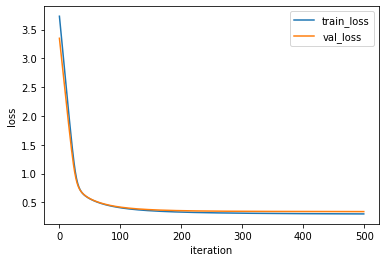

In [ ]:
## batch size 32 / 128 비교해보자.
minibatch_net = MinibatchNetwork(l2=0.01, batch_size = 32)
minibatch_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 500)
minibatch_net.score(x_val_scaled,y_val)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

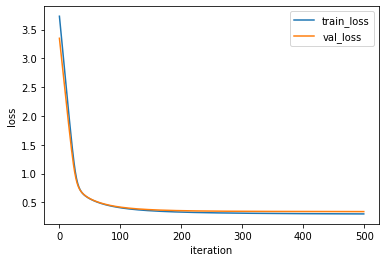

In [ ]:
## batch size 32 / 128 비교해보자.
minibatch_net = MinibatchNetwork(l2=0.01, batch_size = 128)
minibatch_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 500)
minibatch_net.score(x_val_scaled,y_val)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

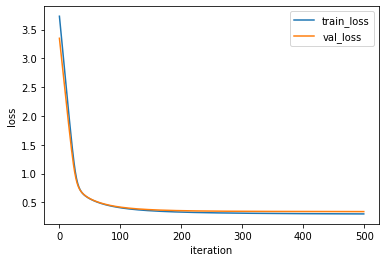

In [ ]:
## batch size  512 비교해보자.
minibatch_net = MinibatchNetwork(l2=0.01, batch_size = 512)
minibatch_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 500)
minibatch_net.score(x_val_scaled,y_val)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

## 사이킷런 사용하여 다층 신경망을 훈련해 보자

- 사이킷런 : sklearn.neural_network

- 분류 작업을 위한 MLPClassifier

- 회귀 작업을 위한 MLPRegressor

- MLP: Multi-Layer Perceptron

In [ ]:
# 1. MLPClassifier의 객체 만들기
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (10, ), activation = 'logistic', solver = 'sgd', alpha = 0.01, batch_size = 32, learning_rate_init = 0.1, max_iter = 500)

hidden_layer_sizes : 은닉층의 크기를 정의 (은닉층의 수, 뉴런의 수)
(10개의 뉴런을 가진 2개의 은닉층 -> hidden_layer_sizes = (10,10) )

activation : 활성화 함수

경사 하강법 알고리즘의 종류를 지정 : solver // sgd : 확률적 경사 하강법

alpha : l2 규제 (l1 규제 지원하지 않음 <-효과 미미)



In [ ]:
# 2. 모델 훈련
mlp.fit(x_train_scaled,y_train)
mlp.score(x_val_scaled,y_val)

0.978021978021978